In [20]:
import matplotlib.pyplot as plt
from matplotlib import style
import numpy as np

from sklearn.cluster import KMeans
from sklearn import metrics
from scipy.spatial.distance import cdist
from scipy.stats import multivariate_normal

#custom functions
from helpers import *

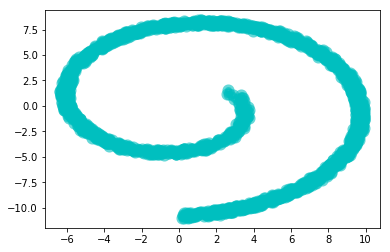

In [24]:
X = np.loadtxt("36_synthetic/class1.txt")


plt.scatter(X[: , 0], X[:, 1], s=50, c = 'c', marker = 'o', linewidths = 5, zorder = 10, alpha = 0.6)
plt.show()  

#### Determine K from KMeans

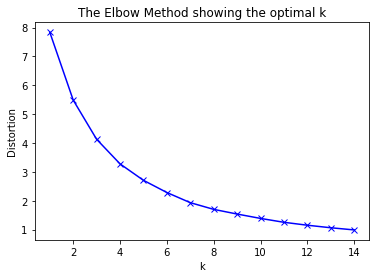

In [25]:
distortions = []
K = range(1,15)
for k in K:
    kmeanModel = KMeans(n_clusters=k).fit(X)
    kmeanModel.fit(X)
    distortions.append(sum(np.min(cdist(X, kmeanModel.cluster_centers_, 'euclidean'), axis=1)) / X.shape[0])
 
# Plot the elbow
plt.plot(K, distortions, 'bx-')
plt.xlabel('k')
plt.ylabel('Distortion')
plt.title('The Elbow Method showing the optimal k')
plt.show()

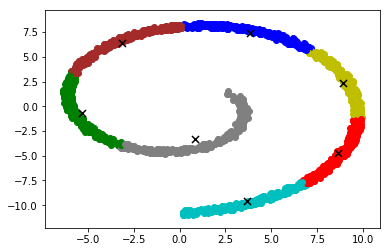

In [26]:
cluster_size = 7
clf = KMeans(n_clusters = cluster_size)
clf.fit(X)

# Gives the final cetnroids of each cluster
centroids = clf.cluster_centers_

# Label of each data-point
labels = clf.labels_


colors = 10*["g", "r", "c", "b", "y","gray", "brown", "tan", "gold", "peru", "tomato", "aqua"]
for i in range(len(X)):
    plt.scatter(X[i][0], X[i][1], c = colors[labels[i]], marker = 'o')

plt.scatter(centroids[:, 0], centroids[:, 1], c= 'k', marker = 'x', s = 50,  zorder = 10)
plt.show()  

In [27]:
clusters = {}

#initialize
for i in range(cluster_size):
    clusters[i] = []

for i,j in zip(X, labels):
    clusters[j].append(i)

for i in clusters:
    clusters[i] = np.array(clusters[i])

#### Visualize Clustering

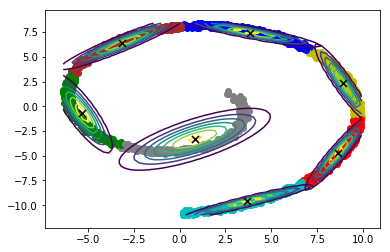

In [28]:
# Our 2-dimensional distribution will be over variables X[0] and X[1]
N = 60
xs = np.linspace(min(X[:,0]), max(X[:,0]), N)
ys = np.linspace(min(X[:,1]), max(X[:,1]), N)
xs, ys = np.meshgrid(xs, ys)

# Pack X and Y into a single 3-dimensional array
pos = np.empty(xs.shape + (2,))
pos[:, :, 0] = xs
pos[:, :, 1] = ys

def multivariate_gaussian(pos, mu, Sigma):
    n = mu.shape[0]
    Sigma_det = np.linalg.det(Sigma)
    Sigma_inv = np.linalg.inv(Sigma)
    N = np.sqrt((2*np.pi)**n * Sigma_det)
    # This einsum call calculates (x-mu)T.Sigma-1.(x-mu) in a vectorized
    # way across all the input variables.
    fac = np.einsum('...k,kl,...l->...', pos-mu, Sigma_inv, pos-mu)

    return np.exp(-fac / 2) / N

# Mean vector and covariance matrix
for index in range(cluster_size):
    mu = centroids[index]
    Sigma = np.cov(np.transpose(clusters[index]))

    # The distribution on the variables X, Y packed into pos.
    Z = multivariate_gaussian(pos, mu, Sigma)

    plt.contour(xs, ys, Z)

for i in range(len(X)):
    plt.scatter(X[i][0], X[i][1], c = colors[labels[i]], marker = 'o')
plt.scatter(centroids[:, 0], centroids[:, 1], c= 'k', marker = 'x', s = 50,  zorder = 10)    
plt.show()

#### Steps

1. KMeans
2. Calculate πk
3. Calculate γ(znk)
4. Calculate new Mean and Sigma 

<img src="EMStep.png" width="600px">

In [29]:
# generalised functions

def cal_pi_k(clusters):
    '''Calculate pi_k from initial KMeans step '''
    pi_k = []
    for i in clusters:
        pi_k.append(clusters[i].shape[0])
    return np.array(pi_k)/X.shape[0]

def recal_pi_k(gamma):
    '''Calculate pi_k(new) after an iteration from Expectation step'''
    K = gamma.shape[1]
    n_size = gamma.shape[0]
    mix = [0]*K
    for i in range(K):
        mix[i] = sum(gamma[:,i])/n_size
        
    return np.array(mix)

def cal_mu(X, gamma):
    '''Calculate Mu(new) after an iteration from Expectation step or initial KMeans step '''
    
    
    K = gamma.shape[1]
    
    new_centroids = np.empty((K,2))
    
    for k in range(K):
        # Denominator
        temp_sum= sum(gamma[:,k])
        
        temp_s = np.array([0,0], dtype='float64')
        
        # Numerator
        for n in range(X.shape[0]):
            temp_s += gamma[n][k]*X[n]
        if temp_sum > 1:
            new_centroids[k] = temp_s/temp_sum
    
    return new_centroids

def cal_sigma(X, gamma, mu):
    
    K = gamma.shape[1]
    new_sigma = np.empty((K , 2,2))
    
    for k in range(K):
        # Denominator
        temp_sum= sum(gamma[:,k])

        temp_s = np.array([[0,0], [0,0]], dtype='float64')
        # Numerator
        for n in range(X.shape[0]):
            t = (X[n] - mu[k]).reshape(1,2)
            temp_s += gamma[n][k] * np.matmul(np.transpose(t), t)

        new_sigma[k] = temp_s / temp_sum
        
    return new_sigma

def build_gamma(X, mix, mu, sigma):
    
    K = mix.shape[0]
    
    tmp = np.zeros([X.shape[0], cluster_size])
    
    for i in range(K):
        mean = mu[i]
        cov = sigma[i]        
        tmp[:, i] = mix[i]*multivariate_normal.pdf(X, mean, cov) # using inbuilt pdf
        #tmp[:, i] = mix[i]*multivariate_gaussian(U, mean, cov)  # self made pdf function
        
    gamma = np.zeros([X.shape[0], cluster_size])

    # Instead of using two data structures temp and gamma we can use only 1
    
    for i in range(X.shape[0]):
        temp_sum = sum(tmp[i, :])
        for j in range(cluster_size):
            gamma[i][j] = tmp[i][j] / temp_sum
            
    return gamma

def threshold(value, limit = 10**-3):
    return value<=10**-3


In [30]:
# GMM class

class gmm:
    def __init__(self, list_mu, list_sigma, list_pi):
        self.list_mu = list_mu
        self.list_sigma = list_sigma
        self.list_pi = list_pi
        
    def predict_scores(self, X):
        scores = np.empty((X.shape[0], 1), dtype = "float64")
        temp_s = 0

        for n in range(X.shape[0]):
            for k in range(self.list_mu.shape[0]):
                temp_s += self.list_pi[k] * multivariate_gaussian(X[n], self.list_mu[k], self.list_sigma[k]);
            scores[n] = temp_s;
        return scores;
        

In [31]:
#Initialize
initial_sigma = []
for index in range(cluster_size):
    initial_sigma.append(np.cov(np.transpose(clusters[index])))

initial_sigma = np.array(initial_sigma).reshape(-1, 2,2)
initial_mu = centroids
initial_pi = cal_pi_k(clusters)

#EM
gamma = build_gamma(X, initial_pi, initial_mu, initial_sigma)

new_pi = recal_pi_k(gamma)
new_mu = cal_mu(X, gamma)
new_sigma = cal_sigma(X, gamma, new_mu)

#Repeat EM
new_gamma = build_gamma(X, new_pi, new_mu, new_sigma)

#If doesn't converge iterate
#pi = recal_pi_k(gamma)


In [32]:
g1 = gmm(new_mu, new_sigma, new_pi)
s1 = g1.predict_scores(X)

In [19]:
X.shape

(1999, 2)

In [30]:
ck_gamma(gamma, new_gamma, 6)

Old : 274.13010728233814, New : 273.4596610059352


#### Gaussian mixtures